In [103]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,cross_val_predict,  KFold,  LeaveOneOut, StratifiedKFold
import numpy as np
from sklearn.model_selection import GroupKFold
import os
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

In [104]:
import sys
sys.path.insert(0, "/cellar/users/mpagadal/Programs/anaconda3/lib/python3.7/site-packages")
from sklearn import linear_model
from regressors import stats

In [2]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [106]:
import sys 
sys.path.append("/cellar/users/mpagadal/Programs/anaconda3/lib/python3.7/site-packages")
sys.path.insert(1, '/cellar/users/mpagadal/Data/scripts')

In [107]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [4]:
import networkx as nx
from ndex2.nice_cx_network import NiceCXNetwork 
import ndex2.client as nc
import ndex2

In [5]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Do a train/test split

In [6]:
mapping=pd.read_csv("/nrnb/users/carterlab/immunotherapy-trials/wxs_rna_mapping_table.tsv",delimiter="\t")
mapping.head()

,normal WXS id,study,patient id,Age,Gender,Response,OS,OS.time,PFS,PFS.time,tumor RNA id,Biopsy Time,tumor WXS id,cancer,partial coding,complete coding
0,SRR3083867.sra,hugo,Pt1,66.0,F,Progressive Disease,Dead,607.0,NaN,NaN,SRR3184279,pre-treatment,SRR3083866,melanoma,1,1
1,SRR3083840.sra,hugo,Pt2,55.0,M,Partial Response,Alive,927.0,NaN,NaN,SRR3184280,pre-treatment,SRR3083839,melanoma,2,1
2,SRR3083842.sra,hugo,Pt3,58.0,M,Partial Response,Dead,691.0,NaN,NaN,NaN,pre-treatment,SRR3083841,melanoma,2,1
3,SRR3083838.sra,hugo,Pt4,62.0,M,Partial Response,Alive,948.0,NaN,NaN,SRR3184281,pre-treatment,SRR3083837,melanoma,2,1
4,SRR3083858.sra,hugo,Pt5,61.0,M,Partial Response,Alive,439.0,NaN,NaN,SRR3184282,pre-treatment,SRR3083857,melanoma,2,1


In [7]:
mapping_filt=mapping[["normal WXS id","cancer","partial coding","study"]]
mapping_filt=mapping_filt.drop_duplicates()

In [8]:
fam=pd.read_csv("/nrnb/users/mpagadal/immunotherapy-trials/normal_wxs/icb.snp.raw",delim_whitespace=True)

In [9]:
mapping_filt=mapping_filt[mapping_filt["normal WXS id"].isin(fam["FID"].tolist())]

In [10]:
mapping_filt.head()

,normal WXS id,cancer,partial coding,study
0,SRR3083867.sra,melanoma,1,hugo
1,SRR3083840.sra,melanoma,2,hugo
2,SRR3083842.sra,melanoma,2,hugo
3,SRR3083838.sra,melanoma,2,hugo
4,SRR3083858.sra,melanoma,2,hugo


In [11]:
# LeaveGroupOut
# cancer="melanoma"
# mapping_cancer=mapping_filt[mapping_filt["cancer"]==cancer]
# X=mapping_cancer["normal WXS id"].tolist()
# y=mapping_cancer["partial coding"].tolist()
# groups=mapping_cancer["study"].tolist()
    
# gss = GroupShuffleSplit(n_splits=10, random_state=0)
# count=0
# for train_index, test_index in gss.split(X,y,groups=groups):
#     train=pd.DataFrame({"FID":np.array(X)[train_index],"IID":np.array(X)[train_index]})
#     test=pd.DataFrame({"FID":np.array(X)[test_index],"IID":np.array(X)[test_index]})
#     train.to_csv("/cellar/users/mpagadal/Data/immunotherapy-trials/prs/LeaveGroupOut/"+cancer+"."+str(count)+".train.txt",header=None,sep="\t",index=None)
#     test.to_csv("/cellar/users/mpagadal/Data/immunotherapy-trials/prs/LeaveGroupOut/"+cancer+"."+str(count)+".test.txt",header=None,sep="\t",index=None)
#     print(train.shape)
#     print(test.shape)
#     count+=1
    
    

In [12]:
#splits for leave one out
# kf = LeaveOneOut()
# for x in mapping_filt["cancer"].unique():
#     mapping_cancer=mapping_filt[mapping_filt["cancer"]==x]
#     X=np.array(mapping_cancer["normal WXS id"])
#     y=np.array(mapping_cancer["partial coding"])
#     for ttrain, ttest in kf.split(X,y):
#         train=pd.DataFrame({"FID":X[ttrain],"IID":X[ttrain]})
#         test=pd.DataFrame({"FID":X[ttest],"IID":X[ttest]})
#         train.to_csv("/cellar/users/mpagadal/Data/immunotherapy-trials/prs/LeaveOneOut/"+x+"."+str(ttest[0])+".train.txt",header=None,sep="\t",index=None)
#         test.to_csv("/cellar/users/mpagadal/Data/immunotherapy-trials/prs/LeaveOneOut/"+x+"."+str(ttest[0])+".test.txt",header=None,sep="\t",index=None)
    

## Get summary data

In [64]:
def calculate_prs(assoc, raw, pheno):
    #get phenotype mapping
    pheno=pd.read_csv(pheno,header=None,sep="\t")
    mp_pheno=dict(zip(pheno[0],pheno[2]))
    #get association files
    assoc=pd.read_csv(assoc,delim_whitespace=True)
    mp_assoc=dict(zip(assoc["SNP"],assoc["OR"]))
    #get genotypes
    raw=pd.read_csv(raw,delimiter=" ")
    raw=raw.set_index("FID")
    raw=raw.iloc[:,5:]
    raw=raw.T
    raw.index=raw.index.str.split("_").str[0]
    raw["OR"]=raw.index.map(mp_assoc)
    #remove null OR 
    raw_score=raw[~raw["OR"].isnull()]
    print(raw_score.shape)
    raw_score["OR"]=np.log10(raw["OR"])
    raw_mult=raw_score.iloc[:,:-1].mul(raw_score["OR"],axis=0)
    #normalize
    prs=raw_mult.sum()
    prs=prs.reset_index()
    prs.columns=["FID","PRS"]
    prs["PRS"]=prs["PRS"]
    prs["pheno"]=prs["FID"].map(mp_pheno)
    return(prs)

(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)
(69, 456)


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(40, 456)
(40, 456)
(25, 456)
(40, 456)
(40, 456)
(40, 456)


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(40, 456)
(40, 456)
(40, 456)
(40, 456)
(40, 456)
(40, 456)


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(40, 456)
(40, 456)
(40, 456)
(40, 456)
(40, 456)


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(40, 456)
(40, 456)
(40, 456)
(40, 456)
(53, 456)


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(40, 456)
(40, 456)
(42, 456)
(40, 456)
(40, 456)


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(36, 456)
(40, 456)
(40, 456)
(40, 456)
(38, 456)


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(40, 456)
(43, 456)
(40, 456)
(40, 456)


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(40, 456)
(40, 456)
(40, 456)
(40, 456)


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(40, 456)
(40, 456)
(39, 456)
(40, 456)
(40, 456)
(40, 456)
(40, 456)
(40, 456)
(40, 456)


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(36, 456)
(40, 456)
(40, 456)
(40, 456)
(40, 456)
(40, 456)


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(40, 456)
(40, 456)
(40, 456)
(40, 456)
(40, 456)
(40, 456)


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(40, 456)
(40, 456)
(40, 456)
(40, 456)
(40, 456)
(40, 456)


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(55, 456)
(55, 456)
(54, 456)
(55, 456)
(55, 456)
(55, 456)


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(55, 456)
(53, 456)
(54, 456)
(54, 456)
(55, 456)
(56, 456)


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(55, 456)
(54, 456)
(55, 456)
(55, 456)
(55, 456)
(55, 456)


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(54, 456)
(54, 456)
(54, 456)
(55, 456)
(55, 456)
(51, 456)


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(53, 456)
(55, 456)
(54, 456)
(55, 456)
(52, 456)
(55, 456)


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(54, 456)
(55, 456)
(55, 456)
(55, 456)


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

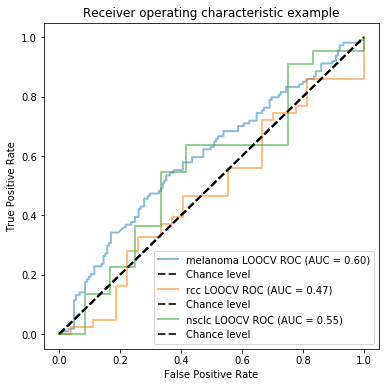

In [65]:
for y in ['melanoma','rcc','nsclc']:
    cancer=y
    sets=[x for x in os.listdir("/cellar/users/mpagadal/Data/projects/germline-immune/disease-relevance/prs/group/LeaveOneOut/") if cancer in x]
    sets=[x.split(".train.txt")[0] for x in sets if "train" in x]

    all_y = []
    all_probs=[]
    
    for x in sets:

        prs=calculate_prs("/cellar/users/mpagadal/Data/projects/germline-immune/disease-relevance/associations/leaveoneout/"+x+".assoc.logistic.add","/nrnb/users/mpagadal/immunotherapy-trials/normal_wxs/icb.snp.raw","/nrnb/users/mpagadal/immunotherapy-trials/normal_wxs/phenos/total_pheno_sd_mapped.txt")
        X_train=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/disease-relevance/prs/group/LeaveOneOut/"+x+".train.txt",header=None,sep="\t")
        X_test=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/disease-relevance/prs/group/LeaveOneOut/"+x+".test.txt",header=None,sep="\t")

        test=prs[(prs["FID"].isin(X_test[0].tolist()))]
        train=prs[prs["FID"].isin(X_train[0].tolist())]
        
        if len(test) == 0:
            print(x)

        clf = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=0)
    
        X=np.array(test["PRS"]).reshape(-1, 1)
        y=np.array(test["pheno"])
    
        all_y.append(y)
        all_probs.append(clf.fit(np.array(train["PRS"]).reshape(-1, 1), train["pheno"]).predict_proba(X)[:,1])

    all_y = np.array(all_y)
    all_probs = np.array(all_probs)

    fpr, tpr, thresholds = roc_curve(all_y,all_probs,pos_label=2)
    roc_auc = auc(fpr, tpr)


    plt.figure(1, figsize=(6,6))
    plt.plot(fpr, tpr, lw=2, alpha=0.5, label=cancer+' LOOCV ROC (AUC = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
plt.savefig("../plots/ROC.avg.pdf")

## Do clustermap

In [66]:
raw=pd.read_csv("/nrnb/users/mpagadal/immunotherapy-trials/normal_wxs/icb.snp.raw",delim_whitespace=True)
raw=raw.set_index("FID")
raw=raw.iloc[:,5:]
raw.head()

,1:1421752:G:A_A,1:10506667:G:A_A,1:10508679:T:C_C,1:79100762:A:T_T,1:89473624:G:A_A,1:89477830:T:C_C,1:89478868:G:A_A,1:89735314:G:A_A,1:150678910:T:C_C,1:161597821:T:G_G,...,19:54848986:C:T_T,19:54849399:T:C_C,19:55025471:C:A_A,19:55145546:T:G_G,19:55173814:G:C_C,19:55174498:T:C_C,19:55175740:C:T_T,19:55175983:T:A_A,19:55225076:C:A_A,21:46328099:T:C_C
FID,,,,,,,,,,,,,,,,,,,,,
SRR478575.sra,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,1,0,0,0
SRR478621.sra,0,0,0,0,1,0,0,0,0,0,...,2,0,0,0,0,1,1,0,0,1
SRR478648.sra,0,0,0,0,0,1,1,1,0,0,...,0,0,1,0,0,1,0,1,0,1
SRR478798.sra,1,0,0,0,0,1,1,1,0,0,...,0,0,0,0,0,1,1,0,0,0
SRR478821.sra,0,0,0,0,1,0,1,1,0,0,...,0,0,1,0,0,0,1,0,0,1


In [67]:
icb=pd.read_csv("../data/immune-microenvironment-icb.tsv",delimiter="\t")
icb.head()

,snps,file,category,maf,variant,rsid,tpm beta,tpm SE,tpm P,REF,...,firebrowse beta,firebrowse SE,firebrowse P,pancan beta,pancan SE,pancan P,p-value,cis tss,gwas,ID_noallele
0,19:54848986:C:T,LAIR1,immunomodulators,0.2168,chr19:g.54848986C>T,rs36068997,-0.189505,0.020223,9.480300e-21,C,...,0.004545,0.020622,8.255600e-01,0.004824,0.020248,8.117140e-01,9.480300e-21,16248.0,['Blood protein levels'],19:54848986
1,19:54848589:C:G,LAIR1,immunomodulators,0.2526,chr19:g.54848589C>G,rs113109589,0.147105,0.019317,2.971350e-14,C,...,0.025998,0.019675,1.864260e-01,0.027989,0.019343,1.479620e-01,2.971350e-14,16645.0,['Velopharyngeal dysfunction'],19:54848589
2,19:54754385:T:G,LILRB2,antigen present,0.3326,chr19:g.54754385T>G,rs2361796,0.139727,0.017345,9.210950e-16,T,...,-0.018438,0.017799,3.002820e-01,-0.022086,0.017484,2.065590e-01,9.210950e-16,23289.0,['Creatine kinase levels'],19:54754385
3,1:150678910:T:C,CTSS,immunomodulators,0.3971,chr1:g.150678910T>C,rs1336899,0.126770,0.017082,1.296960e-13,T,...,0.132358,0.017305,2.309320e-14,0.138944,0.017029,3.957010e-16,3.957010e-16,23761.0,"['Lung function (FVC)', 'Lung function (FEV1)'...",1:150678910
4,3:184026703:C:T,PSMD2,immunomodulators,0.4736,chr3:g.184026703C>T,rs6845,-0.107432,0.016608,1.055230e-10,C,...,-0.151142,0.016849,3.752580e-19,-0.150738,0.016523,9.352130e-20,9.352130e-20,-8335.0,NaN,3:184026703


In [33]:
raw_icb=raw.copy()
raw_icb.columns=[x.split("_")[0] for x in raw_icb.columns]
raw_icb.columns=[x.rsplit(":",2)[0] for x in raw_icb.columns]

In [36]:
raw_icb=raw_icb[[x.rsplit(":",2)[0] for x in icb["snps"].tolist()]]

In [44]:
pheno=pd.read_csv("/nrnb/users/mpagadal/immunotherapy-trials/normal_wxs/phenos/total_pheno_sd_mapped.txt",header=None,delimiter="\t")
responders=pheno[pheno[2]==2][0].tolist()
pheno.head()

,0,1,2
0,SRR3083867.sra,SRR3083867.sra,1
1,SRR3083840.sra,SRR3083840.sra,2
2,SRR3083842.sra,SRR3083842.sra,2
3,SRR3083838.sra,SRR3083838.sra,2
4,SRR3083858.sra,SRR3083858.sra,2


In [42]:
raw_icb=raw_icb.T

In [51]:
pheno_sort=pheno.sort_values(by=2)

In [55]:
pts=[x for x in pheno_sort[0].tolist() if x != "SRR5134831.sra"]

In [57]:
raw_icb=raw_icb[pts]

In [60]:
col_colors=[]

for x in raw_icb.columns:
    if x in responders:
        col_colors.append("red")
    else:
        col_colors.append("blue")

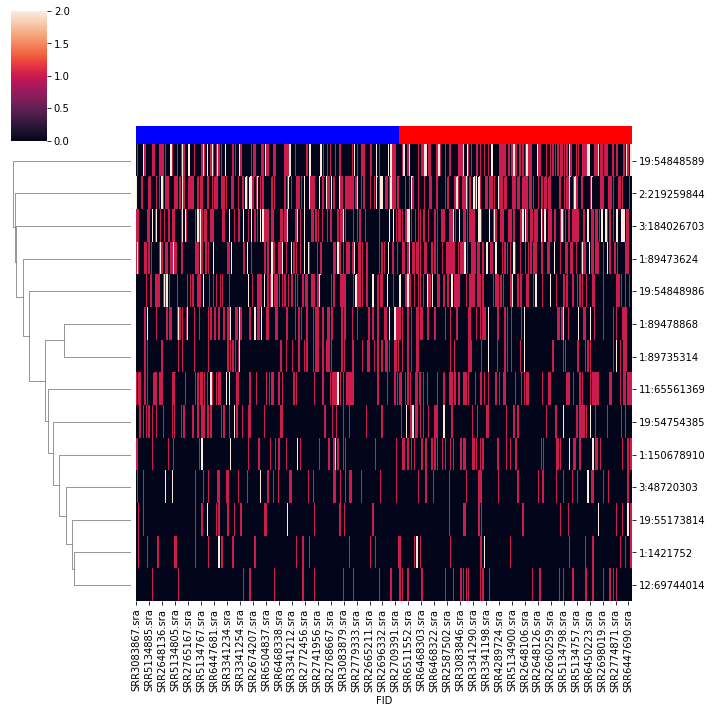

In [61]:
sns.clustermap(raw_icb,col_colors=col_colors,col_cluster=False)

## Get burden scores

hugo
switching
switching
switching
switching
switching
switching
switching
0.0006666101741134887
0.10855380234903306
vanallen
switching
switching
switching
switching
switching
2.3330297873293463e-08
0.10744672547029893
miao
switching
switching
switching
switching
0.9786155551755926
-0.0007723498744931501
snyder
switching
switching
switching
switching
switching
switching
0.0010561836682974996
0.07185067975586905
riaz
switching
switching
switching
switching
switching
2.413746778204771e-05
0.12999621737485814
rizvi
switching
switching
switching
switching
switching
0.014181884487267555
0.08755221386800335


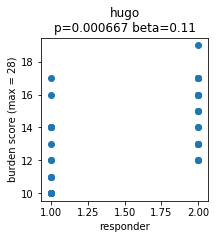

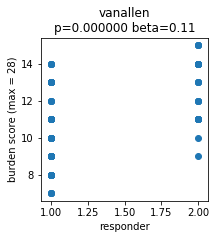

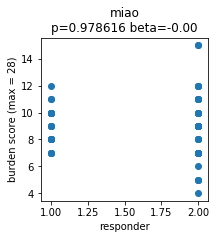

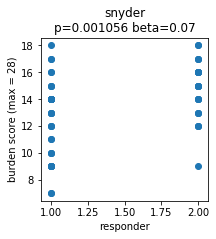

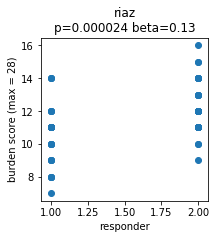

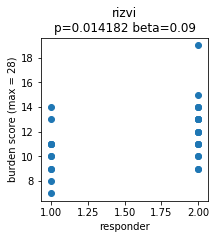

In [159]:
for a in ["hugo","vanallen","miao","snyder","riaz","rizvi"]:
    fig = plt.figure(figsize=(3,3))
    print(a)
    assoc=pd.read_csv("../associations/metal/"+a+".assoc.logistic.add",delimiter="\t")
    assoc["snps_noallele"]=assoc["ID"].str.rsplit(":",2).str[0]
    assoc_sig=assoc[assoc["snps_noallele"].isin([x.rsplit(":",2)[0] for x in icb["snps"].tolist()])]
    
    raw_burden=pd.DataFrame()
    for i,row in assoc_sig.iterrows():
        snps=[x for x in raw.columns if row["snps_noallele"] in x][0]
        min_allele=snps.split("_")[1]
        if min_allele == row["A1"]:
            raw_burden[snps]=raw[snps]
        else:
            print("switching")
            raw_burden[snps]=raw[snps].map({2:0,0:2})
    
        if row["OR"]<1:
            print("switching")
            raw_burden[snps]=raw_burden[snps].map({2:0,1:1,0:2})
    
    raw_burden["score"]=raw_burden.sum(axis=1) 
    raw_burden["pheno"]=raw_burden.index.map(mp_pheno)
    raw_burden=raw_burden[~raw_burden["pheno"].isnull()]
    s=pd.read_csv("/cellar/users/mpagadal/Data/immunotherapy-trials/sets/"+a+".txt",header=None,delimiter="\t")
    raw_burden=raw_burden[raw_burden.index.isin(s[0].tolist())]
    
    ols = linear_model.LinearRegression()
    X=raw_burden["score"].values.reshape(-1, 1)
    y=raw_burden["pheno"].values.reshape(-1, 1)
        
    X = sm.add_constant(X)
        
    model=sm.OLS(y,X)
    results=model.fit()
        
    print(results.pvalues[1])
    print(results.params[1])
    
    plt.scatter(raw_burden["pheno"],raw_burden["score"])
    plt.title("{0}\np={1:.6f} beta={2:.2f}".format(a,results.pvalues[1],results.params[1]))
    plt.xlabel("responder")
    plt.ylabel("burden score (max = 28)")
    fig.savefig("../plots/burden."+a+".pdf")

    

In [145]:
s=pd.read_csv("/cellar/users/mpagadal/Data/immunotherapy-trials/sets/riaz.txt",header=None,delimiter="\t")

In [129]:
assoc=pd.read_csv("../associations/metal/vanallen.assoc.logistic.add",delimiter="\t")
assoc["snps_noallele"]=assoc["ID"].str.rsplit(":",2).str[0]

In [130]:
assoc_sig=assoc[assoc["snps_noallele"].isin([x.rsplit(":",2)[0] for x in icb["snps"].tolist()])]

In [131]:
mp_pheno=dict(zip(pheno[0],pheno[2]))

In [132]:
raw_burden=pd.DataFrame()
for i,row in assoc_sig.iterrows():
    snps=[x for x in raw.columns if row["snps_noallele"] in x][0]
    min_allele=snps.split("_")[1]
    if min_allele == row["A1"]:
        raw_burden[snps]=raw[snps]
    else:
        print("switching")
        raw_burden[snps]=raw[snps].map({2:0,0:2})
    
    if row["OR"]<1:
        print("switching")
        raw_burden[snps]=raw_burden[snps].map({2:0,1:1,0:2})

switching
switching
switching
switching
switching


In [133]:
raw_burden["score"]=raw_burden.sum(axis=1) 

In [134]:
raw_burden["pheno"]=raw_burden.index.map(mp_pheno)

In [135]:
raw_burden=raw_burden[~raw_burden["pheno"].isnull()]

In [136]:
s=pd.read_csv("/cellar/users/mpagadal/Data/immunotherapy-trials/sets/vanallen.txt",header=None,delimiter="\t")

In [137]:
raw_burden=raw_burden.loc[s[0].tolist()]

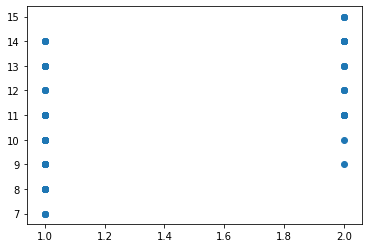

In [138]:
plt.scatter(raw_burden["pheno"],raw_burden["score"])

In [139]:
        ols = linear_model.LinearRegression()
        X=raw_burden["score"].values.reshape(-1, 1)
        y=raw_burden["pheno"].values.reshape(-1, 1)
        
        X = sm.add_constant(X)
        
        model=sm.OLS(y,X)
        results=model.fit()
        
        print(results.pvalues[1])

2.3330297873293463e-08


In [140]:
results.params

array([0.08562954, 0.10744673])

## Get RNA

In [23]:
with open('/nrnb/users/carterlab/immunotherapy-trials/rna/all_immunotherapy_tpm.json', 'r') as f:
    icb_tpm = json.load(f)
rna=pd.DataFrame.from_dict(icb_tpm)

In [24]:
rna+=1
rna=np.log2(rna)

In [25]:
rna.index=rna.index.str.split(".").str[0]

In [26]:
with open('/cellar/users/mpagadal/Data/resources/tcga/ensembl_map.json', 'r') as f:
    ensembl = json.load(f)

In [27]:
ensembl={k.split(".")[0]:v for k,v in ensembl.items()}

In [28]:
rna["gene name"]=rna.index.map(ensembl)

In [29]:
rna=rna[~(rna["gene name"].isnull())]

In [31]:
#get mapping file
mapping=pd.read_csv("/nrnb/users/carterlab/immunotherapy-trials/wxs_rna_mapping_table.tsv",delimiter="\t")
mapping=mapping[~(mapping["tumor RNA id"].isnull())]
mp_geno2rna=dict(zip(mapping["tumor RNA id"],mapping["normal WXS id"]))

In [32]:
rna.index=rna["gene name"]

In [33]:
rna=rna.T
rna.index=rna.index.str.split(".sra").str[0]

In [34]:
rna["geno_id"]=rna.index.map(mp_geno2rna)

In [35]:
rna_filt=rna[~(rna["geno_id"].isnull())]
rna_filt.index=rna_filt["geno_id"]

In [36]:
del rna_filt["geno_id"]
rna_filt=rna_filt.reset_index()

In [37]:
rna_filt=rna_filt.rename(columns={"geno_id":"FID"})

In [38]:
mp_study=dict(zip(mapping["normal WXS id"],mapping["study"]))
mp_time=dict(zip(mapping["normal WXS id"],mapping["Biopsy Time"]))

In [39]:
rna_filt["study"]=rna_filt["FID"].map(mp_study)
rna_filt["time"]=rna_filt["FID"].map(mp_time)

In [42]:
rna_geno_filt=rna_filt[~(rna_filt["time"].isin(["On","on-treatment"]))]

In [46]:
print(rna_geno_filt.shape)
rna_geno_filt.head()

(183, 54761)


gene name,FID,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,...,RP11-309M23.1,AMDP1,BX649553.1,BX649553.2,BX649553.3,BX649553.4,MIR3690,AJ271736.10,study,time
0,SRR5134823.sra,3.52356,2.45418,5.5738,2.72028,1.90689,3.52857,6.39318,5.48414,4.1127,...,0,0.0285692,0,0,0,0,0,0,riaz,Pre
1,SRR6504839.sra,2.96347,0.189034,4.3799,2.62293,3.45022,4.0018,4.39438,3.30597,4.77505,...,0,0,0,0,0,0,0,0.124328,miao,NaN
2,SRR2724351.sra,2.91073,0.214125,5.05441,2.19219,3.87774,0.575312,3.2765,3.60644,5.23458,...,0,0,0,0,0,0,0,0,vanallen,NaN
4,SRR6511550.sra,4.93876,0,4.64212,1.4489,0.659925,4.42761,4.55459,4.92932,2.88166,...,0,0,0,0,0,0,0,1.38405,miao,NaN
5,SRR3083852.sra,2.80116,0,5.75756,2.19849,1.848,1.84398,3.90689,3.8953,3.0018,...,0,0,0,0,0,0,0,0.687061,hugo,pre-treatment


In [49]:
mp_cd274=dict(zip(rna_geno_filt["FID"],rna_geno_filt["CD274"]))

In [54]:
rna_geno_filt["study"].value_counts()

riaz        85
vanallen    39
miao        33
hugo        26
Name: study, dtype: int64

In [55]:
rna_geno_filt["cancer"]=rna_geno_filt["study"].map({"riaz":"melanoma","vanallen":"melanoma","miao":"rcc","hugo":"melanoma"})

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [57]:
pheno=pd.read_csv("/nrnb/users/mpagadal/immunotherapy-trials/normal_wxs/phenos/total_pheno_mapped_partial.txt",header=None,sep="\t")
mp_pheno=dict(zip(pheno[0],pheno[2]))

In [59]:
rna_geno_filt["partial coding"]=rna_geno_filt["FID"].map(mp_pheno)

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [60]:
rna_geno_filt

gene name,FID,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,...,BX649553.1,BX649553.2,BX649553.3,BX649553.4,MIR3690,AJ271736.10,study,time,cancer,partial coding
0,SRR5134823.sra,3.52356,2.45418,5.5738,2.72028,1.90689,3.52857,6.39318,5.48414,4.1127,...,0,0,0,0,0,0,riaz,Pre,melanoma,2
1,SRR6504839.sra,2.96347,0.189034,4.3799,2.62293,3.45022,4.0018,4.39438,3.30597,4.77505,...,0,0,0,0,0,0.124328,miao,NaN,rcc,1
2,SRR2724351.sra,2.91073,0.214125,5.05441,2.19219,3.87774,0.575312,3.2765,3.60644,5.23458,...,0,0,0,0,0,0,vanallen,NaN,melanoma,1
4,SRR6511550.sra,4.93876,0,4.64212,1.4489,0.659925,4.42761,4.55459,4.92932,2.88166,...,0,0,0,0,0,1.38405,miao,NaN,rcc,2
5,SRR3083852.sra,2.80116,0,5.75756,2.19849,1.848,1.84398,3.90689,3.8953,3.0018,...,0,0,0,0,0,0.687061,hugo,pre-treatment,melanoma,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,SRR5134752.sra,3.45154,0.475085,5.8525,2.34483,2.24793,0.687061,4.09761,5.24907,3.63343,...,0,0,0,0,0,1.02148,riaz,Pre,melanoma,1
186,SRR3083864.sra,4.5552,0.0143553,4.63169,1.83996,1.9855,2.01792,2.76765,5.10601,3.66334,...,0,0,0,0,0,0.0143553,hugo,pre-treatment,melanoma,2
188,SRR5134809.sra,4.73064,0,6.24375,3.66221,3.82985,5.54071,2.57289,5.91361,4.42089,...,0,0,0,0,0,0.400538,riaz,Pre,melanoma,1
189,SRR5134912.sra,4.7301,0,6.04045,2.62994,2.59455,3.77505,5.3978,5.49121,3.61706,...,0,0,0,0,0,0,riaz,Pre,melanoma,2


In [63]:
#splits for leave one out
kf = LeaveOneOut()
for x in rna_geno_filt["cancer"].unique():
    rna_geno_filt_cancer=rna_geno_filt[rna_geno_filt["cancer"]==x]
    X=np.array(rna_geno_filt_cancer["FID"])
    y=np.array(rna_geno_filt_cancer["partial coding"])
    for ttrain, ttest in kf.split(X,y):
        train=pd.DataFrame({"FID":X[ttrain],"IID":X[ttrain]})
        test=pd.DataFrame({"FID":X[ttest],"IID":X[ttest]})
        train.to_csv("/cellar/users/mpagadal/Data/projects/germline-immune/disease-relevance/prs/group/LeaveOneOutrna/"+x+"."+str(ttest[0])+".train.txt",header=None,sep="\t",index=None)
        test.to_csv("/cellar/users/mpagadal/Data/projects/germline-immune/disease-relevance/prs/group/LeaveOneOutrna/"+x+"."+str(ttest[0])+".test.txt",header=None,sep="\t",index=None)
    

In [69]:
sets=[x for x in os.listdir("/cellar/users/mpagadal/Data/projects/germline-immune/disease-relevance/prs/group/LeaveOneOutrna/") if "train" in x]

In [73]:
len([x.split(".train.txt")[0] for x in sets])

183

(69, 456)
0      0.001141
1      0.004856
2      0.001771
3      0.001105
4      0.002424
         ...   
450    0.007120
451    2.149594
452    1.359842
453    0.009673
454    1.390658
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000630
1      0.004175
2      0.001416
3      0.001101
4      0.001837
         ...   
450    0.006377
451    2.149361
452    1.359240
453    0.009059
454    1.390362
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000936
1      0.004612
2      0.001597
3      0.000975
4      0.002066
         ...   
450    0.006594
451    2.149488
452    1.359368
453    0.009301
454    1.390571
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000585
1      0.004265
2      0.001711
3      0.001205
4      0.001821
         ...   
450    0.007143
451    2.149631
452    1.359663
453    0.009048
454    1.390355
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000724
1      0.004432
2      0.001466
3      0.000932
4      0.001922
         ...   
450    0.006639
451    2.149355
452    1.359353
453    0.009032
454    1.390151
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000700
1      0.004520
2      0.001721
3      0.001409
4      0.001979
         ...   
450    0.007318
451    2.149783
452    1.359564
453    0.009927
454    1.390635
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000463
1      0.004439
2      0.001461
3      0.001101
4      0.001849
         ...   
450    0.007312
451    2.149856
452    1.359680
453    0.009566
454    1.390329
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000836
1      0.004582
2      0.001571
3      0.001055
4      0.002139
         ...   
450    0.006873
451    2.149708
452    1.359979
453    0.009523
454    1.390389
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000649
1      0.004374
2      0.001608
3      0.000943
4      0.001861
         ...   
450    0.006623
451    2.149535
452    1.359252
453    0.009236
454    1.390223
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000650
1      0.004485
2      0.001860
3      0.001267
4      0.001948
         ...   
450    0.006918
451    2.149509
452    1.359498
453    0.008950
454    1.390234
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000534
1      0.004289
2      0.001567
3      0.001023
4      0.001978
         ...   
450    0.006593
451    2.149395
452    1.359203
453    0.009220
454    1.390034
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000873
1      0.004447
2      0.001780
3      0.001208
4      0.002049
         ...   
450    0.006695
451    2.149751
452    1.359415
453    0.009231
454    1.390396
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000791
1      0.004451
2      0.001795
3      0.000957
4      0.001915
         ...   
450    0.007079
451    2.149850
452    1.359523
453    0.009678
454    1.390614
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000678
1      0.004537
2      0.001805
3      0.001073
4      0.002081
         ...   
450    0.006752
451    2.149490
452    1.359338
453    0.009347
454    1.390434
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000892
1      0.004707
2      0.001684
3      0.001125
4      0.002259
         ...   
450    0.006792
451    2.149661
452    1.359580
453    0.009451
454    1.390626
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000884
1      0.004738
2      0.001825
3      0.001006
4      0.002231
         ...   
450    0.007015
451    2.149481
452    1.359699
453    0.009592
454    1.390553
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000846
1      0.004605
2      0.001446
3      0.000921
4      0.001832
         ...   
450    0.006780
451    2.149583
452    1.359384
453    0.009108
454    1.390337
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000867
1      0.004428
2      0.001810
3      0.001221
4      0.002123
         ...   
450    0.007218
451    2.149512
452    1.359424
453    0.009370
454    1.390558
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000541
1      0.004297
2      0.001546
3      0.000981
4      0.001875
         ...   
450    0.006828
451    2.149263
452    1.359275
453    0.008997
454    1.390037
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000710
1      0.004353
2      0.001438
3      0.000886
4      0.001915
         ...   
450    0.006454
451    2.149439
452    1.359243
453    0.008968
454    1.390259
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000639
1      0.004599
2      0.001726
3      0.000963
4      0.002000
         ...   
450    0.007160
451    2.149660
452    1.359452
453    0.009694
454    1.390667
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000848
1      0.004679
2      0.001685
3      0.001001
4      0.002036
         ...   
450    0.007055
451    2.149706
452    1.359674
453    0.009711
454    1.390656
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000795
1      0.004706
2      0.001827
3      0.001267
4      0.002128
         ...   
450    0.006993
451    2.149602
452    1.359669
453    0.009516
454    1.390389
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000790
1      0.004554
2      0.001564
3      0.000998
4      0.002012
         ...   
450    0.007136
451    2.149776
452    1.359722
453    0.009627
454    1.390613
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000806
1      0.004542
2      0.001356
3      0.000919
4      0.001989
         ...   
450    0.006656
451    2.149503
452    1.359290
453    0.009224
454    1.390276
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000994
1      0.004666
2      0.001892
3      0.001325
4      0.002142
         ...   
450    0.007332
451    2.149794
452    1.359610
453    0.009794
454    1.390764
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000870
1      0.004643
2      0.001706
3      0.001038
4      0.002105
         ...   
450    0.006995
451    2.149470
452    1.359595
453    0.009384
454    1.390308
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000785
1      0.004405
2      0.001611
3      0.001062
4      0.001949
         ...   
450    0.007064
451    2.149755
452    1.359608
453    0.009625
454    1.390588
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000925
1      0.004470
2      0.001494
3      0.000942
4      0.001990
         ...   
450    0.006873
451    2.149584
452    1.359505
453    0.009345
454    1.390508
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000923
1      0.004343
2      0.001694
3      0.000678
4      0.001854
         ...   
450    0.006523
451    2.149523
452    1.359276
453    0.009393
454    1.390605
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000687
1      0.004516
2      0.001433
3      0.000856
4      0.001869
         ...   
450    0.006690
451    2.149379
452    1.359304
453    0.009029
454    1.390162
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000693
1      0.004289
2      0.001422
3      0.001031
4      0.001872
         ...   
450    0.006498
451    2.149583
452    1.359229
453    0.009087
454    1.390032
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000884
1      0.004648
2      0.001919
3      0.001099
4      0.002119
         ...   
450    0.007204
451    2.149463
452    1.359883
453    0.009115
454    1.390250
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000827
1      0.004522
2      0.001735
3      0.000971
4      0.002073
         ...   
450    0.007085
451    2.149485
452    1.359384
453    0.009440
454    1.390449
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000669
1      0.004279
2      0.001470
3      0.000839
4      0.001756
         ...   
450    0.006454
451    2.149376
452    1.359303
453    0.009021
454    1.390088
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000588
1      0.004375
2      0.001592
3      0.000945
4      0.002042
         ...   
450    0.006647
451    2.149381
452    1.359408
453    0.009131
454    1.390135
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000745
1      0.004166
2      0.001610
3      0.000937
4      0.001824
         ...   
450    0.006419
451    2.149400
452    1.358947
453    0.008800
454    1.390176
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000892
1      0.004748
2      0.001812
3      0.001135
4      0.002090
         ...   
450    0.007574
451    2.150283
452    1.359924
453    0.009883
454    1.390877
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004395
2      0.001501
3      0.000978
4      0.002070
         ...   
450    0.006419
451    2.149512
452    1.359238
453    0.008680
454    1.389987
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000778
1      0.004467
2      0.001565
3      0.000908
4      0.002014
         ...   
450    0.006776
451    2.149504
452    1.359260
453    0.009227
454    1.390190
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000689
1      0.004471
2      0.001869
3      0.001084
4      0.001998
         ...   
450    0.006831
451    2.149595
452    1.359312
453    0.009302
454    1.390603
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.001106
1      0.005065
2      0.001842
3      0.001098
4      0.002491
         ...   
450    0.007075
451    2.149422
452    1.359656
453    0.009726
454    1.390522
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000869
1      0.004430
2      0.001490
3      0.001157
4      0.001870
         ...   
450    0.006644
451    2.149630
452    1.359250
453    0.009311
454    1.390262
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000824
1      0.004559
2      0.001681
3      0.001198
4      0.002107
         ...   
450    0.007150
451    2.149758
452    1.359433
453    0.009630
454    1.390447
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000857
1      0.004542
2      0.001804
3      0.001140
4      0.002129
         ...   
450    0.007157
451    2.149576
452    1.359645
453    0.009636
454    1.390564
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000628
1      0.004394
2      0.001624
3      0.001054
4      0.001882
         ...   
450    0.006967
451    2.149804
452    1.359386
453    0.009840
454    1.391046
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000749
1      0.004391
2      0.001563
3      0.001103
4      0.001878
         ...   
450    0.006857
451    2.149816
452    1.359506
453    0.009401
454    1.390409
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000824
1      0.004638
2      0.001656
3      0.000970
4      0.001965
         ...   
450    0.006720
451    2.149405
452    1.359433
453    0.008997
454    1.390405
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000935
1      0.004679
2      0.001968
3      0.001074
4      0.002065
         ...   
450    0.007270
451    2.149438
452    1.359772
453    0.009467
454    1.390682
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.001128
1      0.004867
2      0.001458
3      0.001002
4      0.002326
         ...   
450    0.006842
451    2.149579
452    1.359431
453    0.009802
454    1.390699
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000820
1      0.004351
2      0.001464
3      0.001094
4      0.001894
         ...   
450    0.006743
451    2.149538
452    1.359304
453    0.009137
454    1.390326
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000441
1      0.004153
2      0.001556
3      0.000749
4      0.001623
         ...   
450    0.006778
451    2.149669
452    1.359475
453    0.009006
454    1.390399
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000628
1      0.004324
2      0.001400
3      0.001207
4      0.001896
         ...   
450    0.006965
451    2.149823
452    1.359383
453    0.009654
454    1.390328
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000681
1      0.004307
2      0.001379
3      0.000827
4      0.001785
         ...   
450    0.006426
451    2.149437
452    1.359155
453    0.008882
454    1.390128
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000738
1      0.004276
2      0.001421
3      0.000850
4      0.001828
         ...   
450    0.006435
451    2.149364
452    1.359274
453    0.008892
454    1.390154
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000633
1      0.004403
2      0.001735
3      0.000999
4      0.001762
         ...   
450    0.006994
451    2.149979
452    1.359814
453    0.009722
454    1.390494
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000896
1      0.004507
2      0.001575
3      0.001158
4      0.002008
         ...   
450    0.007035
451    2.150228
452    1.359799
453    0.009621
454    1.391402
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000692
1      0.004369
2      0.001865
3      0.001102
4      0.001950
         ...   
450    0.006876
451    2.149534
452    1.359291
453    0.009356
454    1.390331
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000689
1      0.004195
2      0.001584
3      0.001026
4      0.002005
         ...   
450    0.006507
451    2.149273
452    1.359368
453    0.009048
454    1.390238
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000940
1      0.004685
2      0.001540
3      0.000867
4      0.002104
         ...   
450    0.006495
451    2.149616
452    1.359685
453    0.009233
454    1.390567
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000786
1      0.004604
2      0.001712
3      0.000985
4      0.002009
         ...   
450    0.007041
451    2.149564
452    1.359525
453    0.009290
454    1.390284
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000695
1      0.004486
2      0.001573
3      0.000973
4      0.001942
         ...   
450    0.006885
451    2.149511
452    1.359666
453    0.009532
454    1.390399
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000621
1      0.004306
2      0.001499
3      0.001132
4      0.001831
         ...   
450    0.006624
451    2.149720
452    1.359635
453    0.009196
454    1.390290
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000795
1      0.004560
2      0.001734
3      0.001057
4      0.001981
         ...   
450    0.007244
451    2.149747
452    1.359691
453    0.009479
454    1.390576
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000663
1      0.004358
2      0.001730
3      0.000894
4      0.001839
         ...   
450    0.006561
451    2.149478
452    1.359336
453    0.009044
454    1.390178
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000305
1      0.004439
2      0.001564
3      0.001232
4      0.001918
         ...   
450    0.007218
451    2.149857
452    1.359458
453    0.009636
454    1.390405
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000711
1      0.004461
2      0.001923
3      0.001204
4      0.001930
         ...   
450    0.007109
451    2.149629
452    1.359507
453    0.009213
454    1.390466
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000700
1      0.004285
2      0.001595
3      0.001069
4      0.001882
         ...   
450    0.006774
451    2.149621
452    1.359290
453    0.009246
454    1.390415
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000753
1      0.004307
2      0.001602
3      0.000702
4      0.001876
         ...   
450    0.006444
451    2.149614
452    1.359454
453    0.008998
454    1.390175
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000685
1      0.004610
2      0.001583
3      0.001216
4      0.002108
         ...   
450    0.007412
451    2.149820
452    1.359815
453    0.009974
454    1.390655
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

(69, 456)
0      0.000782
1      0.004549
2      0.001668
3      0.000828
4      0.002025
         ...   
450    0.007215
451    2.149810
452    1.359501
453    0.009615
454    1.390646
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000771
1      0.004368
2      0.001452
3      0.000991
4      0.001875
         ...   
450    0.006517
451    2.149430
452    1.359237
453    0.008978
454    1.390250
Name: PRS, Length: 455, dtype: float64
(69, 456)
0      0.000752
1      0.004482
2      0.001615
3      0.001025
4      0.001973
         ...   
450    0.006863
451    2.149604
452    1.359478
453    0.009328
454    1.390400
Name: PRS, Length: 455, dtype: float64


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

EmptyDataError: No columns to parse from file

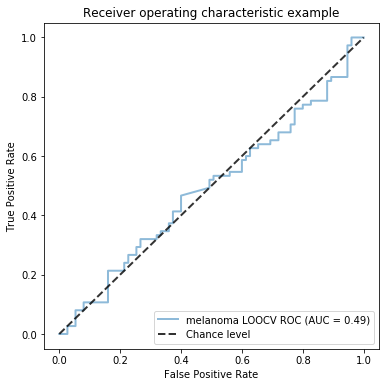

In [76]:
for y in ['melanoma','rcc']:
    cancer=y
    sets=[x for x in os.listdir("/cellar/users/mpagadal/Data/projects/germline-immune/disease-relevance/prs/group/LeaveOneOutrna/") if cancer in x]
    sets=[x.split(".train.txt")[0] for x in sets if "train" in x]

    all_y = []
    all_probs=[]
    
    for x in sets:

        prs=calculate_prs("/cellar/users/mpagadal/Data/projects/germline-immune/disease-relevance/associations/leaveoneoutrna/"+x+".assoc.logistic.add","/nrnb/users/mpagadal/immunotherapy-trials/normal_wxs/icb.snp.raw","/nrnb/users/mpagadal/immunotherapy-trials/normal_wxs/phenos/total_pheno_sd_mapped.txt")
        X_train=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/disease-relevance/prs/group/LeaveOneOutrna/"+x+".train.txt",header=None,sep="\t")
        X_test=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/disease-relevance/prs/group/LeaveOneOutrna/"+x+".test.txt",header=None,sep="\t")
        
        prs["CD274"]=prs["FID"].map(mp_cd274)
        prs["CD274"]=prs["CD274"].fillna(0)
        prs["PRS"]=prs["CD274"]+prs["PRS"]
        print(prs["PRS"])
        
        test=prs[(prs["FID"].isin(X_test[0].tolist()))]
        train=prs[prs["FID"].isin(X_train[0].tolist())]
        
        if len(test) == 0:
            print(x)

        clf = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=0)
    
        X=np.array(test["PRS"]).reshape(-1, 1)
        y=np.array(test["pheno"])
    
        all_y.append(y)
        all_probs.append(clf.fit(np.array(train["PRS"]).reshape(-1, 1), train["pheno"]).predict_proba(X)[:,1])

    all_y = np.array(all_y)
    all_probs = np.array(all_probs)

    fpr, tpr, thresholds = roc_curve(all_y,all_probs,pos_label=2)
    roc_auc = auc(fpr, tpr)


    plt.figure(1, figsize=(6,6))
    plt.plot(fpr, tpr, lw=2, alpha=0.5, label=cancer+' LOOCV ROC (AUC = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
p#lt.savefig("../plots/ROC.pdf")

In [7]:
pheno=pd.read_csv("/nrnb/users/mpagadal/immunotherapy-trials/normal_wxs/phenos/total_pheno_mapped_partial.txt",header=None,sep="\t")
mp_pheno=dict(zip(pheno[0],pheno[2]))

In [8]:
sets=[x for x in range(10)]

In [9]:
cancer="melanoma"

(64, 5)
(38, 5)
(110, 5)
(67, 5)
(67, 5)
(38, 5)
(67, 5)
(38, 5)
(64, 5)
(64, 5)


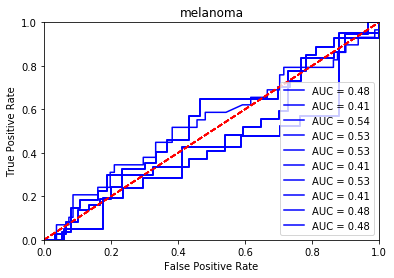

In [10]:
for x in sets:
    prs=pd.read_csv("/cellar/users/mpagadal/Data/immunotherapy-trials/prs/prsice2/"+cancer+"."+str(x)+"/"+cancer+"."+str(x)+".best",delimiter=" ")
    prs["pheno"]=prs["FID"].map(mp_pheno)
    X_test=pd.read_csv("/cellar/users/mpagadal/Data/immunotherapy-trials/prs/LeaveGroupOut/"+cancer+"."+str(x)+".test.txt",header=None,sep="\t")
    test=prs[(prs["FID"].isin(X_test[0].tolist()))]
    print(test.shape)
    
    fpr, tpr, thresholds = metrics.roc_curve(np.array(test["pheno"].tolist()),np.array(test["PRS"].tolist()), pos_label=2)
    roc_auc =metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.legend(loc = 'lower right')
    plt.title(cancer)

    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    

## Get snp sets

In [233]:
cancer="rcc"

In [234]:
sets=[x for x in os.listdir("/cellar/users/mpagadal/Data/immunotherapy-trials/prs/LeaveOneOut") if cancer in x]
sets=[x.split(".train.txt")[0] for x in sets if "train" in x]

In [236]:
compiled=pd.DataFrame()

for x in sets:
    summary=pd.read_csv("/cellar/users/mpagadal/Data/immunotherapy-trials/prs/prsice3/"+x+"/"+x+".summary",delimiter="\t")
    thres=summary["Threshold"][0]

    snps=pd.read_csv("/cellar/users/mpagadal/Data/immunotherapy-trials/prs/prsice3/"+x+"/"+x+".snp",delimiter="\t")
    snps=snps[snps["P"]<thres]
    compiled=compiled.append(snps)

In [237]:
snp_counts=compiled["SNP"].value_counts().reset_index()

In [238]:
snp_counts

,index,SNP
0,19:54848986:C:T,70
1,5:79855876:T:C,70
2,19:55175740:C:T,70
3,2:216296224:T:C,70
4,3:145789609:T:C,70
...,...,...
194,13:97417610:A:G,1
195,11:114027908:T:C,1
196,1:161572353:T:C,1
197,19:54743056:C:T,1


In [239]:
snp_lst=snp_counts[snp_counts["SNP"]>len(sets)*0.9]["index"].tolist()
print(len(snp_lst))

180


In [240]:
snp_lst

['19:54848986:C:T',
 '5:79855876:T:C',
 '19:55175740:C:T',
 '2:216296224:T:C',
 '3:145789609:T:C',
 '1:150678910:T:C',
 '19:54800371:T:C',
 '1:150134735:A:G',
 '11:65645354:A:G',
 '5:79596274:C:T',
 '19:52247181:A:C',
 '19:54752624:T:C',
 '6:24403549:C:A',
 '12:102119014:T:G',
 '1:7969014:G:A',
 '6:160543123:T:C',
 '16:23719751:C:T',
 '5:96079402:C:T',
 '11:60103112:T:C',
 '6:32683653:G:A',
 '6:159042876:C:A',
 '19:54701846:G:A',
 '19:52130638:C:A',
 '19:7813863:G:A',
 '19:52130488:G:A',
 '12:113348661:C:T',
 '7:6067019:A:C',
 '19:52246321:C:T',
 '22:16371114:A:G',
 '9:100211869:T:C',
 '3:49732699:C:T',
 '1:161599654:G:T',
 '19:54849399:T:C',
 '15:42439444:C:T',
 '1:89735314:G:A',
 '7:70755998:T:C',
 '20:55429824:G:A',
 '16:88717074:G:A',
 '5:68219038:A:G',
 '1:89652071:T:C',
 '11:66064126:T:C',
 '20:36008161:T:C',
 '15:27425249:G:A',
 '5:96230844:G:A',
 '1:89473624:G:A',
 '4:74857682:A:G',
 '11:19842316:A:G',
 '3:48231919:T:G',
 '6:160272430:C:T',
 '19:52265776:T:G',
 '3:48720303:G:A'

In [241]:
snp_lst=snp_lst+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in snp_lst]

In [242]:
annot=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/snp-tables/immune-microenvironment-associations.tsv",delimiter="\t")

In [243]:
annot_filt=annot[annot["snps"].isin(snp_lst)]

In [244]:
prs_set=annot_filt[["snps","file"]]
prs_set["cancer"]=cancer

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [245]:
prs_set["file"].value_counts()

CCBL2      8
LILRB4     8
TREX1      8
CTSW       6
LAIR1      6
          ..
DBNDD1     1
SLC25A5    1
ITGB2      1
NEO1       1
LYN        1
Name: file, Length: 79, dtype: int64

In [246]:
prs_set.to_csv(cancer+".prsice.set",index=None,sep="\t")

## Get all prsice sets

In [247]:
net_df=pd.DataFrame()

for x in ["rcc","nsclc","melanoma"]:
    df=pd.read_csv(x+".prsice.set",delimiter="\t")
    net_df=net_df.append(df)

In [248]:
G=nx.Graph()

for i,row in net_df.iterrows():
    G.add_edge(row["snps"],row["cancer"])
    G.add_edge(row["snps"],row["file"])

In [249]:
final = ndex2.create_nice_cx_from_networkx(G)
final.upload_to('http://public.ndexbio.org', username = 'meghanasp21', password = 'student16')

Generating CX


'http://public.ndexbio.org/v2/network/2e013786-0c5f-11eb-9eee-0ac135e8bacf'

In [201]:
net_df.to_csv("response.snps.tsv",index=None,sep="\t")

,snps,file,cancer
36,1:89477830:T:C,CCBL2,nsclc
384,19:15792996:T:G,STAT1,nsclc
400,19:54848986:C:T,LAIR1,nsclc
477,3:184026703:C:T,PSMD2,nsclc
482,19:15792996:T:G,PSMD2,nsclc
846,12:102119014:T:G,GNPTAB,nsclc
915,11:65645354:G:A,CTSW,nsclc
924,12:113357193:A:G,OAS1,nsclc
1050,19:52148804:A:C,SIGLEC5,nsclc
1237,19:7813863:G:A,CD209,nsclc
